<div align="center">
    <br><b><font size="6">Unmasking Fraud in Bank Account Openings: <br> A Comprehensive Analysis of the BAF Dataset</font></b><br><br>
</div>

Welcome to this notebook where we embark on a comprehensive analysis of the BAF dataset and explore fraud detection in online bank account openings. First, we will delve into a detailed description of the BAF dataset, which centers around detecting fraudulent applications in a large consumer bank. Next, we will dive into the key performance metrics used for evaluating the effectiveness of methods on this dataset. Moreover, we will emphasize the significance of fairness metrics to ensure unbiased decision-making in the high-stakes banking domain. Subsequently, we will introduce the methods employed to address fraud detection, taking into account both performance aspects and fairness considerations.

# Outline:
<br>
<ul>
    <li><b>Bank Account Fraud (BAF) Dataset</b></li><br>
    <li><b>Dataset Preparation</b></li><br>
    <li><b>Metrics</b></li><br>
    <li><b>Methods</b></li><br>
    <li><b>Results</b></li><br>
    <li><b>Hyperparameter Tuning</b></li><br>
    <li><b>Fraud Detection on Other Variants of BAF Dataset</b></li><br>
</ul>

# Bank Account Fraud (BAF) Dataset

![BAF Description](figures/baf_description.png)

The **[BAF dataset](https://arxiv.org/pdf/2211.13358.pdf)** focuses on detecting **fraudulent online bank account opening applications** in a large consumer bank. The scenario involves fraudsters attempting to **impersonate someone or create fictional individuals** to gain access to banking services and carry out illicit activities. The costs incurred by the bank due to these fraudulent activities cannot be traced back to the true identity of the fraudsters. This dataset was accepted at **NeurIPS 2022**.


The use case of **fraud detection in the banking domain** is considered **high-stakes**, as positive predictions (flagged as fraudulent) result in the **rejection of customer bank account applications**, while negative predictions grant access to new bank accounts and associated credit cards. As holding a bank account is a basic right in the European Union, fraud detection in this context is of great societal importance. Due to the risk of unfair decision-making using machine learning systems, banks and merchants are at the forefront of adopting fair machine learning methods.

The dataset consists of **individual applications**, with each row representing an application made on an online platform. The label indicating fraud or legitimacy is stored in the "**is_fraud**" column, where a positive instance represents a fraudulent attempt and a negative instance represents a legitimate application. The dataset spans **eight months** from February to September, with varying **fraud prevalence figures** ranging from **0.85% to 1.5%** across different months. The distribution of applications also varies from month to month, ranging from **9.5% to 15%**.

To produce the dataset, a **generative model** is trained with some of original features in the dataset. These features are the top thirty most important features selected from the top-performing LightGBM models, considering expressiveness, interpretability, and redundancy. **Differential privacy** is enforced by perturbing each column in the original dataset using a Laplacian noise mechanism. Additional obfuscation measures are applied to certain applicant data, such as age and income categorization, to enhance privacy.

The **CTGAN models** are trained on the perturbed dataset with the selected features, and the dataset is augmented with a column representing the month of application to incorporate temporal information. A total of **70 trained CTGAN models** are created, and the generative models are evaluated based on **predictive performance metrics** and **statistical similarity** between the real and generated data. The goal is to ensure that models trained on the generated datasets are effective at the task and that the generated distribution remains realistic and faithful to the original data.

The **performance metric** focuses on defining a relevant threshold and metric for fraud detection, specifically targeting a **5% false positive rate (FPR)** and measuring the **true positive rate (TPR)** at that point. This metric strikes a balance between detecting fraud and minimizing customer attrition. The **fairness metric** aims to ensure that the probability of a legitimate application being wrongly classified as fraudulent is independent of the sensitive attribute value. The **fairness ratio** is calculated by comparing the FPRs of different groups, emphasizing predictive equality.

![BAF Variants](figures/baf_variants.png)

The BAF dataset includes **six dataset variants**, each with pre-determined and controllable bias patterns. These variants introduce disparities in group sizes, prevalence, and separability to stress test predictive performance and fairness. The base dataset and its variants are derived from the same underlying distribution, with biases present in the base dataset also present in the variants. The goal is to provide a diverse set of algorithmic fairness challenges for evaluating and improving models' performance and fairness.

Overall, the BAF dataset serves as a valuable resource for studying fraud detection in the banking domain, addressing privacy concerns, and exploring the challenges of fairness in machine learning applications.

If you want to know more about the dataset, you can read the data sheet available [here](https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf).

# Dataset Preparation

<p>Now, we want to introduce the <code>BAFDataset</code> class provides a convenient way to load, preprocess, and split the BAF dataset for use in machine learning experiments. The class contains three primary functions that work together to load the data, split it into train and test sets, and preprocess the categorical features via one-hot encoding.</p>

<p>Here's a summary of each function within the BAFDataset class:</p>

<ul>
    <li><code>load_baf(file_path)</code>: This function loads the specified subset of the BAF dataset as a pandas DataFrame. The available subsets are 'Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', and 'Variant V'. The function reads the data from a CSV file and drops the 'device_fraud_count' column as it is not needed for further processing.</li>
    <li><code>train_test_split(df, month)</code>: This function splits the BAF dataset into train and test sets based on the specified month. The month-based split is inspired by the method proposed in the original paper. Months 0-5 are assigned to the train set, and months 6-7 are assigned to the test set. The function returns a tuple containing the train and test sets.</li>
    <li><code>one_hot_encode_categorical(X_train, X_test)</code>: This function preprocesses the categorical features in the BAF dataset by one-hot encoding them. One-hot encoding is a technique that converts categorical features into binary columns for each category/label, making it easier for machine learning models to process the data. The function identifies the categorical features in the dataset, applies one-hot encoding separately for the train and test sets to avoid data leakage, and then combines the transformed data with the numerical features to form the final one-hot encoded train and test sets.</li>

</ul>

<p>The BAFDataset class streamlines the process of preparing the BAF dataset for machine learning experiments, handling loading, train-test splitting, and preprocessing tasks in a clear and organized manner.</p>


In [1]:
# Import the necessary packages and libraries
import pandas as pd
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from baf import BAFDataset
from metrics import calculate_tpr_at_fpr, calculate_fairness_metrics
import os
import joblib
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(os.environ)
seed = 100
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

environ({'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-jewtay', 'SLURM_NODEID': '0', 'SLURM_TASK_PID': '7437', '_ModuleTable002_': 'L3BrZ3MvbW9kdWxlZmlsZXM6L3BrZ3MvZW52aXJvbm1lbnQtbW9kdWxlcyIsfQ==', 'SLURM_PRIO_PROCESS': '0', 'LANG': 'en_US', 'SLURM_SUBMIT_DIR': '/', 'HOSTNAME': 'gpu101', 'LMOD_SYSTEM_DEFAULT_MODULES': 'Core/StdEnv', '__LMOD_REF_COUNT__LMFILES_': '/opt/modulefiles/Core/StdEnv.lua:1', 'SLURM_CPUS_PER_TASK': '4', 'ENVIRONMENT': 'BATCH', 'ROCR_VISIBLE_DEVICES': '0', 'SLURM_PROCID': '0', 'SLURM_JOB_GID': '11019', 'SLURMD_NODENAME': 'gpu101', 'SLURM_TASKS_PER_NODE': '1', 'S_COLORS': 'auto', 'SLURM_NNODES': '1', 'USER': 'jewtay', 'JUPYTERHUB_BASE_URL': '/', 'SLURM_GET_USER_ENV': '1', '__LMOD_REF_COUNT_MODULEPATH': '/opt/modulefiles:1;/pkgs/modulefiles:1;/pkgs/environment-modules:1', '__LMOD_REF_COUNT_LOADEDMODULES': 'Core/StdEnv:1', 'PWD': '/', 'SLURM_JOB_NODELIST': 'gpu101', 'HOME': '/h/jewtay', 'SLURM_CLUSTER_NAME': 'vaughan2', 'SLURM_NODELIST': 'gpu101', 'SLURM_GPUS_ON_NODE': 

In [2]:
# Instantiate the BAF class
ds = BAFDataset()

In [3]:
# set the path to the dataset and models

base_path = "/ssd003/projects/aieng/public/anomaly_detection_datasets/BAF"
model_path = "/ssd003/projects/aieng/public/anomaly_detection_models/BAF"

variant = "Base.csv"

In [4]:
# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

In [5]:
# Split the dataset into train and test sets
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

In [6]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w
96843,0.8,0.153411,-1,105,30,0.003467,-0.906840,AC,1779,1147.615990,...,1,-1,0,200.0,0,INTERNET,3.911696,linux,0,1
96844,0.8,0.442439,-1,107,40,0.021131,-1.553115,AC,1195,10788.642570,...,1,-1,0,200.0,0,INTERNET,23.696737,other,0,2
96845,0.9,0.328328,-1,79,70,0.009110,-0.801146,AC,845,8504.451753,...,1,-1,0,2000.0,0,INTERNET,2.803927,windows,0,1
96846,0.7,0.033834,-1,28,30,0.004707,-1.171706,AB,1697,6011.217859,...,1,28,0,1000.0,0,INTERNET,5.262441,windows,1,2
96847,0.9,0.150643,-1,164,40,0.012221,-0.227823,AB,1474,8378.324044,...,1,5,0,1500.0,0,INTERNET,5.728984,windows,0,1


In [7]:
# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

In [8]:
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,...,16,17,18,19,20,21,22,23,24,25
96843,0.8,0.153411,-1,105,30,0.003467,-0.906840,1779,1147.615990,3076.384487,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
96844,0.8,0.442439,-1,107,40,0.021131,-1.553115,1195,10788.642570,5790.128646,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
96845,0.9,0.328328,-1,79,70,0.009110,-0.801146,845,8504.451753,5912.163054,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
96846,0.7,0.033834,-1,28,30,0.004707,-1.171706,1697,6011.217859,5505.127811,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
96847,0.9,0.150643,-1,164,40,0.012221,-0.227823,1474,8378.324044,4930.672316,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Metrics



![BAF Metrics](figures/baf_metrics.png)

Now we want to discuss the metrics we used in evaluating the performance and fairness of the models. The metrics play a crucial role in assessing the effectiveness of the models in detecting fraud and maintaining fairness in the decision-making process.

#### `calculate_tpr_at_fpr()`

This function calculates the true positive rate (TPR), false positive rate (FPR), and threshold based on a given FPR limit. It takes the predicted scores on the test set, the test set target variable, and the FPR limit as inputs. The function then calculates the ROC curve points and obtains the **threshold and TPR based on the FPR limit**. The TPR represents the proportion of actual positives correctly classified, while the FPR represents the proportion of actual negatives incorrectly classified as positives. These metrics are commonly used in fraud detection to strike a balance between detecting fraud and minimizing customer attrition. The function stores the calculated metrics in a dictionary and returns it.

#### `calculate_fairness_metrics()`

This function calculates fairness metrics on the predicted scores. It takes the predicted scores on the test set, the test set target variable, and the test set features as inputs. The function initializes a fairness evaluator and calculates the ROC curve points to obtain the threshold. It then creates a dataframe with the scores, labels, and age, and calculates the fairness metrics. The fairness metric in this scenario focuses on ensuring that the probability of a legitimate applicant being wrongly classified as fraudulent is independent of their sensitive attribute value. To assess this, the function calculates the ratio between false positive rates (FPRs) across different groups, referred to as predictive equality. The fairness ratio is obtained by **dividing the FPR of the group with the lowest observed FPR by the FPR of the group with the highest FPR**. This metric helps evaluate and mitigate potential biases in the model's predictions related to sensitive attributes. The function returns the fairness ratio as a measure of fairness.


In [9]:
# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

# Methods

Now, let's delve into the methods employed to analyze the BAF dataset. The following section will outline the approaches and techniques used to address fraud detection in this high-stakes banking context.

## Logistic Regression

Logistic regression is a popular statistical model used for **binary classification tasks**. It is particularly useful when the **outcome variable is categorical**, with two possible values such as "yes" or "no," "true" or "false," or **"normal"** or **"anomaly"**. The goal of logistic regression is to **estimate the probability** that an observation belongs to a certain class based on a set of input features. Mathematically, logistic regression applies the logistic function (also known as the sigmoid function) to a linear combination of input features. This is expressed as:

<p align="center">\[ p(x) = \frac{1}{1 + e^{-z}} \]</p>

<p>where p(x) is the probability of belonging to a certain class, \( e \) is the base of the natural logarithm, and \( z \) is the linear combination of input features and their respective coefficients:</p>

<p align="center">\[ z = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n \]</p>

Here, β₀, β₁, β₂, ..., βₙ are the **coefficients** (also known as weights) associated with each input feature x₁, x₂, ..., xₙ. The logistic regression model learns the optimal values of these coefficients by minimizing a cost function, typically the log loss or cross-entropy loss. This process is done through techniques like maximum likelihood estimation or gradient descent. The coefficients obtained from logistic regression represent the **impact of each feature** on the probability of the outcome class. Logistic regression is widely used in various domains, including medicine, finance, and marketing, for tasks such as predicting disease presence, credit risk assessment, and customer churn prediction.

Here, we apply Logistic Regression on the data:

Uncomment and run this section and skip the next two cells if you don't want to train the model from scratch:

In [10]:
# Load the saved Logistic Regression model
# lr_model_path = os.path.join(model_path, f"{variant.split('.')[0]}_lr_model.joblib")
# lr_model = joblib.load(lr_model_path)

In [11]:
lr_model = LogisticRegression(n_jobs=-1)

<code>class_weight</code> is set to <code>None</code> by default. Try setting it to some weights or <code>balanced</code> mode and see how the performance changes.


To calculate class weights, you can use this formula:

```python
weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

weight_for_class_0 = len(X_train) / (len(X_train[y_train == 0]) * 2)
weight_for_class_1 = len(X_train) / (len(X_train[y_train == 1]) * 2)
```

Or directly use scikit-learn for this purpose:

```python
sklearn.utils.class_weight.compute_class_weight(class_weight, classes, y)
```

After calculating the weights for each class, you can pass them as dictionary to model's fit function.

In [12]:
# Start measuring training time
start_time = time.time()

# Training the model
lr_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
lr_training_time = end_time - start_time
print(f"Training Time: {lr_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Logistic Regression")] = {"Training Time":lr_training_time}

Training Time: 195.22572445869446 seconds


In [13]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
lr_scored_test = lr_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
lr_inference_time = end_time - start_time
print(f"Inference Time: {lr_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Logistic Regression")] = {"Inference Time":lr_inference_time}

Inference Time: 0.16954326629638672 seconds


If you want to save the model, you can use:

```python
import joblib
joblib.dump(model, "PATH_TO_SAVE_MODEL")
```

In [14]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, lr_scored_test, fpr_lim=0.05)
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")
performance_results[(variant.split('.')[0], 'Logistic Regression')] = metrics_dict

Model TPR: 0.2057, Model FPR: 0.0499, Model Threshold: 0.1125, Model AUROC: 0.6797


In [15]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, lr_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Logistic Regression')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.9136


## Random Forest

Random forest is a powerful ensemble learning algorithm used for both **classification** and **regression** tasks. It combines multiple **decision trees** to make predictions. The 'forest' in random forest refers to a collection of decision trees. Each decision tree in the random forest is built on a random subset of the training data and a random subset of the input features. This randomness helps to create diverse and uncorrelated trees.

A decision tree is a popular supervised learning algorithm used for both classification and regression tasks. It creates a flowchart-like model where **each internal node represents a feature**, **each branch represents a decision rule**, and **each leaf node represents the outcome or prediction**.  The decision tree algorithm builds the tree by recursively partitioning the data based on the values of the input features. It selects the best feature and the optimal split point at each step, aiming to maximize the homogeneity of the target variable within each partition. The homogeneity is typically measured using metrics such as **Gini impurity** or information gain. To make a **prediction** using a decision tree, we traverse the tree from the root node to a leaf node based on the feature values of the instance being classified or predicted. The outcome or prediction associated with that leaf node is then assigned to the instance.

To make a prediction using a random forest, let's assume we have a random forest with \(N\) decision trees. For **classification**, each tree independently predicts the class label using its corresponding subset of features and training samples. The final prediction is determined by **majority voting**, where the class label with the highest count across all trees is selected. For **regression**, each tree independently predicts the target variable, and the final prediction is obtained by **averaging** the predictions of all the trees.

<p>Mathematically, let's denote the random forest prediction as \(y_{\text{RF}}\). For classification, the prediction is given by:</p>

<p align="center">\[y_{\text{RF}} = \text{argmax}\left(\sum_{i=1}^{N} \mathbb{F}(y_i = c)\right)\]</p>

<p>where \(y_i\) represents the predicted class label of the \(i\)th tree, \(\mathbb{F}\) is the indicator function, and \(c\) is the class label being considered. For regression, the prediction is given by:</p>

<p align="center">\[y_{\text{RF}} = \frac{1}{N}\sum_{i=1}^{N} y_i\]</p>

<p>where \(y_i\) represents the predicted target value of the \(i\)th tree.</p>

One of the key advantages of random forest is its ability to handle **high-dimensional data** with many input features. It can capture **complex relationships** between features and target variables, handle **missing values** and **outliers**, and provide measures of **feature importance**.

The random forest algorithm also addresses the problem of **overfitting**, which can occur with individual decision trees. By combining multiple trees, random forest reduces overfitting and improves generalization performance. Additionally, random forest has mechanisms to estimate the **out-of-bag (OOB) error**, which provides an unbiased estimate of the model's performance without the need for a separate validation set.

Random forest has a wide range of applications, including but not limited to, **fraud detection**, **sentiment analysis**, **customer churn prediction**, and **medical diagnosis**. It is a popular and versatile algorithm in machine learning due to its **robustness**, **accuracy**, and **interpretability**.

Uncomment and run this section and skip the next two cells if you don't want to train the model from scratch:

In [16]:
# Load the saved Random Forest model
# rf_model_path = os.path.join(model_path, f"{variant.split('.')[0]}_rf_model.joblib")
# rf_model = joblib.load(rf_model_path)

In [17]:
rf_model = RandomForestClassifier(n_jobs=-1)

<code>class_weight</code> is set to <code>None</code> by default. Try setting it to some weights or <code>balanced</code> mode and see how the performance changes.

You can either use from sklearn.utils import class_weight

In [18]:
# Start measuring training time
start_time = time.time()

# Training the model
rf_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
rf_training_time = end_time - start_time
print(f"Training Time: {rf_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Random Forest")] = {"Training Time":rf_training_time}

Training Time: 168.30542469024658 seconds


In [19]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
rf_scored_test = rf_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
rf_inference_time = end_time - start_time
print(f"Inference Time: {rf_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Random Forest")] = {"Inference Time":rf_inference_time}

Inference Time: 2.2137911319732666 seconds


In [20]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, rf_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'Random Forest')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.4288, Model FPR: 0.0415, Model Threshold: 0.09, Model AUROC: 0.8398


In [21]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, rf_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Random Forest')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.9245


## Gradient Boosting 

Gradient boosting is a powerful machine learning technique used for both regression and classification tasks. It is an ensemble method that combines multiple weak prediction models, typically decision trees, to create a strong predictive model. Unlike random forest, which builds independent trees, gradient boosting builds trees in a sequential manner.

The gradient boosting algorithm works by iteratively adding new trees to the model, each one trained to correct the mistakes of the previous trees. At each iteration, the algorithm calculates the gradients of a specified loss function with respect to the predictions made by the existing ensemble. The new tree is then built to minimize this gradient, effectively fitting the residual errors.

<p>To make predictions using a gradient boosting model, let's assume we have a gradient boosting model with \(N\) trees. The prediction \(y_{\text{GB}}\) is obtained by summing the predictions of all the trees, with each tree weighted by a learning rate \(\eta\):</p>

<p align="center">\[y_{\text{GB}} = \sum_{i=1}^{N} \eta \cdot h_i(x)\]</p>

<p>where \(h_i(x)\) represents the prediction made by the \(i\)th tree.</p>

One of the key advantages of gradient boosting is its ability to handle complex and nonlinear relationships in the data. It can automatically capture interactions between features and handle missing values. Gradient boosting is also known for its robustness against outliers and its capability to handle high-dimensional data.

However, gradient boosting is prone to overfitting if the model becomes too complex or if the learning rate is set too high. Regularization techniques such as limiting the maximum depth of the trees or using early stopping can be employed to prevent overfitting.

Gradient boosting has become widely popular and has numerous applications in various domains, including but not limited to, web search ranking, anomaly detection, recommendation systems, and healthcare analytics. It consistently delivers state-of-the-art performance and is favored by many data scientists for its effectiveness and flexibility.


### XGBoost

**XGBoost** (Extreme Gradient Boosting) is an advanced implementation of gradient boosting, known for its exceptional performance and efficiency. It is widely used in machine learning competitions and has become a popular choice in various data science projects.

XGBoost builds upon the principles of gradient boosting and introduces several enhancements to improve the model's predictive power and speed. One of the key innovations is its handling of regularization techniques such as **L1 and L2 regularization**, which help control model complexity and prevent overfitting. By incorporating regularization, XGBoost can effectively handle high-dimensional datasets with many features.

Furthermore, XGBoost employs a technique called "column block" for parallel computing, making it significantly faster than traditional gradient boosting implementations. It optimizes the computation by dividing the dataset into column blocks, allowing for efficient parallel processing.

XGBoost supports both **classification and regression** tasks. For classification, it uses a variant of gradient boosting called "gradient boosted trees," where each tree predicts the class probabilities using a softmax transformation. For regression, XGBoost builds a regression tree ensemble.

One of the distinguishing features of XGBoost is its ability to handle **missing values** by automatically learning the best direction to handle them during tree construction. This eliminates the need for imputing missing values before training the model.

XGBoost also provides **interpretable model outputs** by ranking the importance of each feature. It calculates feature importance based on the number of times a feature is used in the tree ensemble and the average gain achieved by splits involving that feature.

Due to its exceptional performance, scalability, and robustness, XGBoost has gained popularity across various domains, including finance, healthcare, e-commerce, and recommendation systems. It is implemented in multiple programming languages, including Python, R, Java, and Scala, making it easily accessible to data scientists and machine learning practitioners.

Uncomment and run this section and skip the next two cells if you don't want to train the model from scratch:

In [22]:
# Load the saved XGBoost model
# xgb_model_path = os.path.join(model_path, f"{variant.split('.')[0]}_xgb_model.joblib")
# xgb_model = joblib.load(xgb_model_path)

In [23]:
# XGBoost model
xgb_model = xgb.XGBClassifier()

One hyperparameter in XGBoost for imbalance classfication is `scale_pos_weight`.

By default, `scale_pos_weight` is set to **1.0, which balances positive and negative examples**. XGBoost **minimizes a loss function during training, with gradients reflecting the error magnitude**. A low gradient signifies a small error, and vice versa.

The `scale_pos_weight` hyperparameter **scales the gradient related to the positive (minority) class**. This encourages the model to **rectify positive class errors more assertively, potentially enhancing predictions**. However, **excessive scaling can result in overfitting the positive class**, harming performance on both classes.

A reasonable default is **the inverse of the class distribution**. For instance, if the minority:majority class ratio is **1:100, setting `scale_pos_weight` to 100 amplifies the impact of minority class errors during training**.

Try different values and see how the performance changes.


In [24]:
# Start measuring training time
start_time = time.time()

# Training the model
xgb_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
xgb_training_time = end_time - start_time
print(f"Training Time: {xgb_training_time} seconds")
training_times_dict[(variant.split('.')[0], "XGBoost")] = {"Training Time":xgb_training_time}

/ssd003/projects/aieng/public/anomaly_detection_environment/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Training Time: 169.00852870941162 seconds


In [25]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
xgb_scored_test = xgb_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
xgb_inference_time = end_time - start_time
print(f"Inference Time: {xgb_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "XGBoost")] = {"Inference Time":xgb_inference_time}

Inference Time: 0.361177921295166 seconds


In [26]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, xgb_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'XGBoost')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5049, Model FPR: 0.0498, Model Threshold: 0.041099999099969864, Model AUROC: 0.8787


In [27]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, xgb_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'XGBoost')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8989


### CatBoost

**CatBoost** is a powerful gradient boosting framework developed by Yandex that is particularly well-suited for working with **categorical features**. It is designed to handle the inherent challenges posed by categorical variables, such as high cardinality and missing values.

One of the key advantages of CatBoost is its ability to automatically handle categorical features without requiring explicit preprocessing. It employs an innovative technique called **ordered boosting**, which utilizes a novel algorithm to process categorical variables directly, eliminating the need for one-hot encoding or label encoding. This simplifies the feature engineering process and helps capture valuable information present in categorical features.

Additionally, CatBoost implements **gradient-based optimization** to handle numerical features effectively. It leverages the power of gradient boosting to learn complex non-linear relationships and interactions between features, resulting in accurate predictions.

CatBoost also includes built-in **robustness** mechanisms to handle missing data in both categorical and numerical features. It can automatically handle missing values during training, reducing the need for imputation.

The framework supports various advanced features, such as **regularization**, **cross-validation**, and **early stopping**, which enhance model generalization and prevent overfitting. CatBoost also provides **interpretability** by offering feature importance analysis and visualization tools to understand the impact of different features on the predictions.

Furthermore, CatBoost is known for its high performance and scalability. It implements **optimized algorithms** to process large datasets efficiently, making it suitable for both small-scale and large-scale applications.

CatBoost is available in multiple programming languages, including Python, R, and Julia, making it accessible to a wide range of users. It integrates well with popular data science libraries and frameworks, enabling seamless integration into existing workflows.

Due to its unique handling of categorical features, robustness, and performance, CatBoost has gained popularity in various domains, including advertising, recommendation systems, and fraud detection. It is widely used by data scientists and machine learning practitioners to achieve accurate predictions with minimal feature engineering efforts.

Uncomment and run this section and skip the next two cells if you don't want to train the model from scratch:

In [28]:
# Load the saved CatBoost model
# cb_model_path = os.path.join(model_path, f"{variant.split('.')[0]}_cb_model.joblib")
# cb_model = joblib.load(cb_model_path)

In [29]:
# CatBoost model
cb_model = cb.CatBoostClassifier(verbose=False)

CatBoost offers two options, `scale_pos_weight` and `class_weights`, to handle imbalanced classification. You have the choice to utilize either of them. Experiment with various values for these options to observe the resulting performance changes.


In [30]:
# Start measuring training time
start_time = time.time()

# Training the model
cb_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
cb_training_time = end_time - start_time
print(f"Training Time: {cb_training_time} seconds")
training_times_dict[(variant.split('.')[0], "CatBoost")] = {"Training Time":cb_training_time}

TBB Warning: The number of workers is currently limited to 3. The request for 31 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Training Time: 116.60564064979553 seconds


In [31]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
cb_scored_test = cb_model.predict_proba(X_test)[:, 1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
cb_inference_time = end_time - start_time
print(f"Inference Time: {cb_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "CatBoost")] = {"Inference Time":cb_inference_time}

Inference Time: 0.2116382122039795 seconds


In [32]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, cb_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'CatBoost')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5101, Model FPR: 0.0499, Model Threshold: 0.0373, Model AUROC: 0.8836


In [33]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, cb_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'CatBoost')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8875


### LightGBM

**Light GBM** (Light Gradient Boosting Machine) is a gradient boosting framework that offers high performance and efficiency for machine learning tasks. It is designed to handle large-scale datasets and has gained popularity for its speed and accuracy.

Light GBM leverages a unique approach to gradient boosting by using a technique called **gradient-based one-sided sampling**. This approach selects only the most informative data instances for building each tree, reducing the computational resources required while maintaining predictive accuracy.

Another important feature of Light GBM is its ability to handle **categorical features** directly. It converts categorical variables into numerical values, which improves the model's performance and reduces the need for manual feature engineering.

Light GBM employs a **leaf-wise tree growth** strategy, where each tree is grown leaf-wise instead of level-wise. This strategy focuses on growing the leaves that contribute the most to the overall objective function, leading to faster convergence and improved efficiency.

The framework also supports various advanced techniques, such as **regularization** (e.g., L1 and L2 regularization), **early stopping**, and **data parallelism**. These techniques enhance model generalization, prevent overfitting, and enable efficient distributed training.

Light GBM is implemented in multiple programming languages, including Python, R, and C++. It provides a user-friendly interface and is compatible with popular machine learning libraries like scikit-learn.

Due to its speed, scalability, and performance, Light GBM is widely used in various domains, including online advertising, recommendation systems, and fraud detection. It has become a go-to choice for data scientists and machine learning practitioners when working with large datasets and requiring fast and accurate models.

Uncomment and run this section and skip the next two cells if you don't want to train the model from scratch:

In [34]:
# Load the saved Light GBM model
# lgbm_model_path = os.path.join(model_path, f"{variant.split('.')[0]}_lgbm_model.joblib")
# lgbm_model = joblib.load(lgbm_model_path)

In [35]:
# Train a model on the data
lgbm_model = lgbm.LGBMClassifier()

<code>class_weight</code> is set to <code>None</code> by default. Try setting it to some weights or <code>balanced</code> mode and see how the performance changes.

In [36]:
# Start measuring training time
start_time = time.time()

# Training the model
lgbm_model.fit(X_train, y_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
lgbm_training_time = end_time - start_time
print(f"Training Time: {lgbm_training_time} seconds")
training_times_dict[(variant.split('.')[0], "Light GBM")] = {"Training Time":lgbm_training_time}

Training Time: 8.637389183044434 seconds


In [37]:
# Start measuring inference time
start_time = time.time()

# predict on the test set
lgbm_scored_test = lgbm_model.predict_proba(X_test)[:,1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
lgbm_inference_time = end_time - start_time
print(f"Inference Time: {lgbm_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "Light GBM")] = {"Inference Time":lgbm_inference_time}

Inference Time: 0.7575802803039551 seconds


In [38]:
# Calculate the  TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, lgbm_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'Light GBM')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5302, Model FPR: 0.05, Model Threshold: 0.0404, Model AUROC: 0.8898


In [39]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, lgbm_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'Light GBM')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}")

Fairness Ratio: 0.8887


## Comparison of Different Gradient Boosting Libraries (XGBoost, CatBoost and Light GBM)

### Differences:
- **Feature Handling**: XGBoost requires explicit preprocessing of categorical features, while CatBoost natively handles them, and LightGBM uses binning techniques for efficient categorical feature handling.
- **Performance and Efficiency**: XGBoost is known for its scalability and optimization, CatBoost emphasizes memory efficiency, and LightGBM offers faster training speed and lower memory usage.
- **Parallelization and Distributed Computing**: All three frameworks support parallelization, but XGBoost and CatBoost also provide options for distributed computing.
- **Implementation and Community Support**: XGBoost has a longer history, a mature implementation, and a large user community. CatBoost and LightGBM are newer but gaining popularity, with active development communities and good documentation.

### Similarities:
- **Gradient Boosting**: All three frameworks are based on the gradient boosting technique.
- **Ensemble Learning**: They create ensembles by combining multiple weak models (decision trees) for improved predictive power.
- **Anomaly Detection**: All three can be used for anomaly detection tasks.
- **Widely Used**: XGBoost, CatBoost, and LightGBM are widely used in various domains and have demonstrated success in many machine learning applications.


## TabNet: Attentive Interpretable Tabular Learning

**TabNet** presents an innovative approach that bridges the gap between two prominent machine learning paradigms: **Decision Trees (DTs)** and **Deep Neural Networks (DNNs)**. The methodology introduced in this work combines the strengths of these two approaches to create a powerful learning framework for real-world **tabular datasets**. While **DNNs lack the transparency and interpretability of DTs**, DTs often struggle to capture the intricacies of complex patterns present in diverse tabular data. TabNet's primary contribution revolves around its meticulously designed architecture, which effectively integrates the output structure of DTs within the flexible framework of DNNs.

The central concept driving TabNet is the emulation of **decision boundaries** akin to those established by DTs. However, TabNet introduces a novel mechanism by leveraging a sequence of **learnable masks** to guide feature selection at each step. These masks, derived through the innovative **sparsemax normalization technique**, offer a dual advantage: they optimize parameter usage efficiently and promote interpretability by **highlighting the most pertinent features**. Moreover, the incorporation of **sparsity regularization** empowers the model with the ability to control the extent of feature selection, a crucial capability when dealing with datasets containing redundant or irrelevant features.

TabNet's architecture excels due to its **sequential multi-step approach**, wherein decisions are iteratively refined by progressively considering the most influential features. Inspired by applications in visual processing and reinforcement learning, the **top-down attention mechanism** equips the model to concentrate on relevant information, effectively tackling the challenges posed by high-dimensional inputs. This results in a dynamic decision process that effectively harnesses the strengths of both local and global features, thereby enhancing TabNet's proficiency in capturing intricate relationships within tabular data.

In essence, TabNet strikes a remarkable balance between **predictive power and interpretability**. Its capability to not only **outperform traditional DTs** but also provide **invaluable insights into feature importance** positions it as a potent solution for learning from tabular datasets. This becomes particularly relevant in domains where comprehending the decision-making process is just as pivotal as achieving accurate predictions.


In [40]:
from sklearn.metrics import roc_curve
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

In [41]:
# Create an instance of TabNet model
clf = TabNetClassifier()

/ssd003/projects/aieng/public/anomaly_detection_environment/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [42]:
# Create a custom metric class to pass to TabNet
class TPR_at_05FPR(Metric):
    def __init__(self):
        self._name = "tpr_at_05fpr"
        self._maximize = True

    def __call__(self, y_true, y_score):
        fpr, tpr, threshold = roc_curve(y_true, y_score[:, 1])
        tpr_at_05fpr = tpr[fpr < 0.05][-1]
        return tpr_at_05fpr

Set 1 for automatic weight balancing or try different values and see how the performance changes.

In [43]:
# Start measuring training time
start_time = time.time()

# Train TabNet
clf.fit(
    X_train.values, 
    y_train.values,
    eval_metric=[TPR_at_05FPR, "auc"],
    max_epochs=5,
    batch_size=512,
    weights=0
)

# End measuring training time
end_time = time.time()

# Storing and printing the time
tabnet_training_time = end_time - start_time
print(f"Training Time: {tabnet_training_time} seconds")
training_times_dict[(variant.split('.')[0], "TabNet")] = {"Training Time":tabnet_training_time}

/ssd003/projects/aieng/public/anomaly_detection_environment/lib/python3.7/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.05198 |  0:01:04s
epoch 1  | loss: 0.04631 |  0:02:06s
epoch 2  | loss: 0.04549 |  0:03:07s
epoch 3  | loss: 0.04523 |  0:04:08s
epoch 4  | loss: 0.04475 |  0:05:09s
Training Time: 793.5279746055603 seconds


In [44]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
tabnet_scored_test = clf.predict_proba(X_test.values)[:,1]

# End measuring inference time
end_time = time.time()

# Storing and printing the time
tabnet_inference_time = end_time - start_time
print(f"Inference Time: {tabnet_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "TabNet")] = {"Inference Time":tabnet_inference_time}

Inference Time: 5.725928068161011 seconds


If you want to save the model, you can use:

```python
clf.save_model("PATH_TO_SAVE_MODEL")
```

In [45]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, tabnet_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'TabNet')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.5069, Model FPR: 0.05, Model Threshold: 0.028200000524520874, Model AUROC: 0.8822


In [46]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, tabnet_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'TabNet')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.9076 



## Autoencoder

Now we want to apply some unsupervised methods for anomaly detection. In this cell, we begin by importing essential libraries required for building and training neural networks, as well as for data preprocessing and evaluation. We also import Scikit-learn libraries for metrics calculation and data scaling.

Following the imports, we define the architecture of the autoencoder model. An autoencoder is a type of neural network consisting of an encoder and a decoder. The purpose of an autoencoder is to learn a compressed representation of input data and then reconstruct the original data from this representation.

We create the `Autoencoder` class as a subclass of `nn.Module`, which is PyTorch's base class for defining neural network modules. The class includes methods for initializing the architecture and performing forward passes.

The encoder is structured using `nn.Sequential`, which is a convenient way to define a sequence of layers. It starts with a linear layer that reduces the input data's dimensionality to the specified `hidden_size`, followed by a rectified linear unit (ReLU) activation function to introduce non-linearity.

The decoder, resembling the encoder but in reverse order, takes the encoded representation and aims to reconstruct the original input data. The simplicity of this architecture allows for easy experimentation with various configurations and layer sizes.

In [47]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In this cell, we set the hyperparameters that will govern the training process of the autoencoder. Hyperparameters are configuration choices that influence the behavior of the neural network during training. It's important to choose appropriate hyperparameters to ensure effective learning and convergence.

We define the `input_size` as the number of features in the input data and `hidden_size` as the number of neurons in the hidden layer of the autoencoder. These values can be adjusted based on the complexity of your data and the desired capacity of the model.

Other hyperparameters include the `batch_size`, which determines the number of data samples processed in each training iteration, the `learning_rate`, which controls the step size during optimization, and the `num_epochs`, which specifies the number of times the entire training dataset is passed through the model.

With the hyperparameters set, we create an instance of the `Autoencoder` class that we defined earlier. This instance represents our neural network model, which will be trained to learn a compressed representation of the input data.

We also define the loss function and optimizer. The loss function (`nn.MSELoss()`) calculates the mean squared error between the reconstructed data and the original data. The optimizer (`optim.Adam()`) implements the Adam optimization algorithm, which updates the model's parameters to minimize the loss during training.


In [48]:
# Hyperparameters
input_size = 50  # Number of input features
hidden_size = 30  # Number of neurons in the hidden layer
batch_size = 512
learning_rate = 0.0001
num_epochs = 5

# Create an instance of the Autoencoder
autoencoder = Autoencoder(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In this cell, we convert the DataFrames to PyTorch tensors using the `torch.tensor` function. This conversion prepares the data for feeding into the neural network model.

With the data in the form of PyTorch tensors, we are now ready to proceed with training the autoencoder model in subsequent cells.

In [49]:
# Convert DataFrame to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In this cell, we begin the training process of the autoencoder neural network. Training a neural network involves iteratively adjusting its parameters to minimize a chosen loss function and improve its performance on the given data.

We create a `train_dataset` using the scaled training data, and a `train_dataloader` using `TensorDataset` and `DataLoader` from PyTorch. The dataloader allows us to efficiently iterate over batches of data during training.

We initiate a loop that runs for a specified number of epochs. In each epoch, the autoencoder processes batches of training data through the network and updates its parameters to reduce the loss. The loss is calculated using the mean squared error (`MSELoss`) between the input data and the reconstructed output.

The `optimizer` then applies gradient descent to adjust the neural network's weights and biases, moving in the direction that minimizes the loss. This process iterates over multiple epochs, gradually improving the autoencoder's ability to capture useful features and create a compressed representation of the data.

At the end of each epoch, we print the loss to monitor the training progress and observe how it decreases over time. This cell establishes the core training loop, and the subsequent cells will focus on evaluating the trained autoencoder's performance and analyzing its results.


In [50]:
# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Start measuring training time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = autoencoder(batch[0])
        loss = criterion(outputs, batch[0])
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# End measuring training time
end_time = time.time()

# Storing and printing the time
ae_training_time = end_time - start_time
print(f"Training Time: {ae_training_time} seconds")
training_times_dict[(variant.split('.')[0], "AE")] = {"Training Time":ae_training_time}

Epoch [1/5], Loss: 109621.1641
Epoch [2/5], Loss: 49789.3008
Epoch [3/5], Loss: 15754.1221
Epoch [4/5], Loss: 4542.7529
Epoch [5/5], Loss: 708.6297
Training Time: 43.37036156654358 seconds


In this cell, we evaluate the performance of the trained autoencoder for anomaly detection on the test data. Anomaly detection involves identifying instances that significantly deviate from the norm in the dataset.

We pass the scaled test data through the trained autoencoder's decoder to obtain reconstructed data. The difference between the original test data and the reconstructed data is used to calculate the reconstruction errors. These errors represent how well the autoencoder is able to recreate the input data.

To calculate the reconstruction errors, we use the mean squared error (`MSELoss`) with the reduction set to `'none'`. This means that the reconstruction error is computed for each individual data point without aggregating.

In [51]:
# Start measuring inference time
start_time = time.time()

# Pass the test data through the autoencoder
with torch.no_grad():
    reconstructed_data = autoencoder(X_test_tensor)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
ae_inference_time = end_time - start_time
print(f"Inference Time: {ae_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "AE")] = {"Inference Time":ae_inference_time}

# Calculate reconstruction errors
reconstruction_errors = ((reconstructed_data - X_test_tensor)**2).mean(dim=1)

# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test.values, reconstruction_errors.numpy(), fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'AE')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, reconstruction_errors.numpy(), X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'AE')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Inference Time: 0.09120416641235352 seconds
Model TPR: 0.0653, Model FPR: 0.0498, Model Threshold: 2304.104736328125, Model AUROC: 0.6174
Fairness Ratio: 0.9207 



## Isolation Forest

The Isolation Forest (iForest) is an **established method** for **spotting anomalies** within datasets. It constructs a **forest of isolation trees** where data points are partitioned based on **random feature choices and values**. Anomalies are identified as points that require **fewer splits to become isolated**, assuming they are **distinct from the majority of data points**. This approach is **effective for simple anomalies** but **struggles when anomalies are complex, high-dimensional, or situated in non-linear data configurations**.

In this cell, we utilize Scikit-learn's Isolation Forest algorithm for anomaly detection. The Isolation Forest algorithm excels in identifying anomalies by isolating them within a tree-based structure. The `IsolationForest` class is imported from the `ensemble` module.

We set the `n_jobs` parameter to -1, which enables the algorithm to leverage all available CPU cores for parallel computations, potentially accelerating the training process. Additionally, we establish a specific random seed, denoted as `seed`, to ensure the reproducibility of results.

The Isolation Forest is trained on the `X_train` dataset, containing the feature values of the training instances. Once trained, we compute anomaly scores for the test data using the `decision_function` method. These scores quantify the extent to which each test instance deviates from the norm, where higher scores indicate a higher probability of being an anomaly.

In [52]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
isolation_forest = IsolationForest(n_jobs=-1, random_state=seed)


# Start measuring training time
start_time = time.time()

# Train
isolation_forest.fit(X_train)

# End measuring training time
end_time = time.time()

# Storing and printing the time
if_training_time = end_time - start_time
print(f"Training Time: {if_training_time} seconds")
training_times_dict[(variant.split('.')[0], "IF")] = {"Training Time":if_training_time}


# Start measuring inference time
start_time = time.time()

# Predict
isolation_scores = isolation_forest.decision_function(X_test)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
if_inference_time = end_time - start_time
print(f"Inference Time: {if_inference_time} seconds")
inference_times_dict[(variant.split('.')[0], "IF")] = {"Inference Time":if_inference_time}

Training Time: 16.452646255493164 seconds
Inference Time: 13.158173322677612 seconds


This cell assesses the performance of the trained Isolation Forest model for anomaly detection. The objective is to gauge its capacity to accurately detect anomalies while managing false positives.

In Isolation Forest, the anomaly scores provided by the decision_function method are calculated as the average path length of an instance in the isolation tree forest. An instance with a shorter average path length is considered more anomalous. However, in terms of interpreting the scores, lower values are more indicative of anomalies. Anomalies are expected to have fewer average path lengths due to their isolated nature.

By negating the scores, you effectively transform the interpretation so that higher negated scores represent higher anomaly likelihood. This aligns better with the common understanding that higher scores indicate higher degrees of anomalous behavior.

In [53]:
# Calculate TPR@5%FPR for Isolation Forest
metrics_dict = calculate_tpr_at_fpr(y_test.values, -isolation_scores, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'IF')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

# Calculate fairness metrics for Isolation Forest
fairness_ratio = calculate_fairness_metrics(y_test.values, -isolation_scores, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'IF')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Model TPR: 0.0806, Model FPR: 0.0499, Model Threshold: 0.0155, Model AUROC: 0.5816
Fairness Ratio: 0.8606 



## DeepOD: Deep Learning-Based Anomaly Detection Framework

DeepOD is an open-source Python framework designed for deep learning-based anomaly detection. It offers a unified implementation of various detection models based on PyTorch.

DeepOD currently encompasses 13 deep anomaly detection algorithms in the unsupervised and weakly-supervised paradigms. The framework provides a platform for easy experimentation with these models, and additional baseline algorithms will be incorporated in the future.

**Detection Models:**

The following detection models are included in DeepOD:

| Model       | Venue | Year | Type            | Title
|-------------|-------|------|-----------------|----------------------------------------------------
| Deep SVDD   | ICML  | 2018 | Unsupervised    | Deep One-Class Classification
| REPEN       | KDD   | 2018 | Unsupervised    | Learning Representations of Ultrahigh-dimensional Data for Random Distance-based Outlier Detection
| RDP         | IJCAI | 2020 | Unsupervised    | Unsupervised Representation Learning by Predicting Random Distances
| RCA         | IJCAI | 2021 | Unsupervised    | RCA: A Deep Collaborative Autoencoder Approach for Anomaly Detection
| GOAD        | ICLR  | 2020 | Unsupervised    | Classification-Based Anomaly Detection for General Data
| NeuTraL     | ICML  | 2021 | Unsupervised    | Neural Transformation Learning for Deep Anomaly Detection Beyond Images
| ICL         | ICLR  | 2022 | Unsupervised    | Anomaly Detection for Tabular Data with Internal Contrastive Learning
| DIF         | TKDE  | 2023 | Unsupervised    | Deep Isolation Forest for Anomaly Detection
| SLAD        | ICML  | 2023 | Unsupervised    | Fascinating Supervisory Signals and Where to Find Them: Deep Anomaly Detection with Scale Learning
| DevNet      | KDD   | 2019 | Weakly-Supervised | Deep Anomaly Detection with Deviation Networks
| PReNet      | KDD   | 2023 | Weakly-Supervised | Deep Weakly-supervised Anomaly Detection
| Deep SAD    | ICLR  | 2020 | Weakly-Supervised | Deep Semi-Supervised Anomaly Detection
| FeaWAD      | TNNLS | 2021 | Weakly-Supervised | Feature Encoding with AutoEncoders for Weakly-supervised Anomaly Detection

**Usage Examples:**

DeepOD is user-friendly and can be employed with only a few lines of code. The API style is similar to sklearn and [PyOD](https://github.com/yzhao062/pyod).

```python
# Unsupservised methods
from deepod.models.dsvdd import DeepSVDD
clf = DeepSVDD()
clf.fit(X_train, y=None)
scores = clf.decision_function(X_test)

# Weakly-supervised methods
from deepod.models.devnet import DevNet
clf = DevNet()
clf.fit(X_train, y=semi_y)  # semi_y uses 1 for known anomalies and 0 for unlabeled data
scores = clf.decision_function(X_test)


## ICL: Anomaly Detection for Tabular Data with Internal Contrastive Learning

The **ICL method** focuses on **out-of-class sample detection** in **tabular data**, where the data structure is largely unknown. It aims to **capture the structure** of single training class samples by learning mappings that **maximize the mutual information** between each sample and the **masked-out portion**. This is accomplished through a **contrastive loss**, learning mappings individually for each sample. The score for a test sample is determined by measuring the **contrastive loss of the learned mappings applied to the masked parts** of the sample. ICL **outperforms existing methods** with a substantial accuracy advantage across benchmarks.


**Contrastive learning**, rooted in metric learning and unsupervised representation learning, maximizes similarity between queries and positive samples while minimizing it with negative samples. Existing methods, often using image transformations, **don't apply to tabular data** due to the absence of invariant transformation groups. Qiu et al.'s NeuTraL AD work is a similar method for tabular data but **differs significantly**, utilizing specific masks and single feature extractors.


ICL employs a training set of in-class samples and aims to design a **scoring function** that maps samples to low values if they belong to the same distribution and high values otherwise. Hyperparameters include **k for feature subset size, u for embedding size, and τ for loss temperature**. The method **constructs pairs from each sample and learns mappings to maximize mutual information**. Mutual information maximization is achieved through the **noise contrastive estimation framework**.

In [54]:
from deepod.models.icl import ICL

In [55]:
# unsupervised method
clf = ICL(epochs=5)

In [56]:
# Start measuring training time
start_time = time.time()

# Train ICL
clf.fit(X_train.values, y=None)

# End measuring training time
end_time = time.time()

# Storing and printing the time
icl_training_time = end_time - start_time
print(f"Training Time: {icl_training_time} seconds")

Start Training...
ensemble size: 2
kernel size: 10
ICLNet(
  (enc_f_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=40, out_features=100, bias=False)
        (act_layer): Tanh()
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (1): LinearBlock(
        (linear): Linear(in_features=100, out_features=50, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
      (2): LinearBlock(
        (linear): Linear(in_features=50, out_features=128, bias=False)
        (act_layer): LeakyReLU(negative_slope=0.01)
        (bn_layer): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      )
    )
  )
  (enc_g_net): MLPnet(
    (network): Sequential(
      (0): LinearBlock(
        (linear): Linear(in_features=10, out_features=50, bias=

testing: 100%|██████████| 12422/12422 [00:35<00:00, 347.21it/s]


Training Time: 962.7594134807587 seconds


In [57]:
# Start measuring inference time
start_time = time.time()

# Predict on the test set
icl_scored_test = clf.decision_function(X_test.values)

# End measuring inference time
end_time = time.time()

# Storing and printing the time
icl_inference_time = end_time - start_time
print(f"Inference Time: {icl_inference_time} seconds")

testing: 100%|██████████| 3204/3204 [00:09<00:00, 347.45it/s]


Inference Time: 18.99421787261963 seconds


If you want to save the model, you can use:

```python
torch.save(clf.net.state_dict(), "PATH_TO_SAVE_MODEL")
```

In [58]:
training_times_dict[(variant.split('.')[0], "ICL")] = {"Training Time":icl_training_time}
inference_times_dict[(variant.split('.')[0], "ICL")] = {"Inference Time":icl_inference_time}

In [59]:
# Calculate the TPR@5%FPR on the test set
metrics_dict = calculate_tpr_at_fpr(y_test, icl_scored_test, fpr_lim=0.05)
performance_results[(variant.split('.')[0], 'ICL')] = metrics_dict
print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

Model TPR: 0.0865, Model FPR: 0.0499, Model Threshold: 3.1268, Model AUROC: 0.6172


In [60]:
# Calculate the fairness metrics on the test set
fairness_ratio = calculate_fairness_metrics(y_test, icl_scored_test, X_test, fpr_lim=0.05)
fairness_results[(variant.split('.')[0], 'ICL')] = {"Fairness Ratio":fairness_ratio}
print(f"Fairness Ratio: {fairness_ratio}", "\n")

Fairness Ratio: 0.9998 



In [61]:
import pickle

performance_results_path = os.path.join(model_path, 'performance_results.pkl')
fairness_results_results_path = os.path.join(model_path, 'fairness_results.pkl')
training_times_dict_path = os.path.join(model_path, 'training_times_dict.pkl')
inference_times_dict_path = os.path.join(model_path, 'inference_times_dict.pkl')

with open(performance_results_path, 'wb') as file:
    pickle.dump(performance_results, file)
    
with open(fairness_results_results_path, 'wb') as file:
    pickle.dump(fairness_results, file)
    
with open(training_times_dict_path, 'wb') as file:
    pickle.dump(training_times_dict, file)
    
with open(inference_times_dict_path, 'wb') as file:
    pickle.dump(inference_times_dict, file)

# Results

In the forthcoming section, we will present the results obtained from our comprehensive analysis. We will showcase the performance metrics of the evaluated models on the BAF dataset, delving into their effectiveness in detecting fraudulent online bank account opening applications. Moreover, we will explore the fairness metrics, ensuring unbiased decision-making in the context of different user groups. To assess the real-world applicability of the models, we will provide insights into their training and inference times, offering valuable insights into their efficiency and suitability for practical use.

## Table

Below you can see all the result in one table:

In [62]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [63]:
# concatenate all results together
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)

In [64]:
all_results

TPR     FPR    Threshold   AUROC  Fairness Ratio  \
Base Logistic Regression  0.2057  0.0499     0.112500  0.6797          0.9136   
     Random Forest        0.4288  0.0415     0.090000  0.8398          0.9245   
     XGBoost              0.5049  0.0498     0.041100  0.8787          0.8989   
     CatBoost             0.5101  0.0499     0.037300  0.8836          0.8875   
     Light GBM            0.5302  0.0500     0.040400  0.8898          0.8887   
     TabNet               0.5069  0.0500     0.028200  0.8822          0.9076   
     AE                   0.0653  0.0498  2304.104736  0.6174          0.9207   
     IF                   0.0806  0.0499     0.015500  0.5816          0.8606   
     ICL                  0.0865  0.0499     3.126800  0.6172          0.9998   

                          Training Time  Inference Time  
Base Logistic Regression     195.225724        0.169543  
     Random Forest           168.305425        2.213791  
     XGBoost                 169.008529        0.361178  
     CatBoost                116.605641        0.211638  
     Light GBM                 8.637389        0.757580  
     TabNet                  793.527975        5.725928  
     AE                       43.370362        0.091204  
     IF                       16.452646       13.158173  
     ICL                     962.759413       18.994218

## Plots

The following is 4 plots demonstrating all results for all models:

In [65]:
# Extract TPR values
lr_tpr = df_performance_results.loc[(variant.split('.')[0], 'Logistic Regression'), 'TPR']
rf_tpr = df_performance_results.loc[(variant.split('.')[0], 'Random Forest'), 'TPR']
xgb_tpr = df_performance_results.loc[(variant.split('.')[0], 'XGBoost'), 'TPR']
cb_tpr = df_performance_results.loc[(variant.split('.')[0], 'CatBoost'), 'TPR']
lgbm_tpr = df_performance_results.loc[(variant.split('.')[0], 'Light GBM'), 'TPR']
tabnet_tpr = df_performance_results.loc[(variant.split('.')[0], 'TabNet'), 'TPR']
ae_tpr = df_performance_results.loc[(variant.split('.')[0], 'AE'), 'TPR']
if_tpr = df_performance_results.loc[(variant.split('.')[0], 'IF'), 'TPR']
icl_tpr = df_performance_results.loc[(variant.split('.')[0], 'ICL'), 'TPR']
tpr_values = [lr_tpr, rf_tpr, xgb_tpr, cb_tpr, lgbm_tpr, tabnet_tpr, ae_tpr, if_tpr, icl_tpr]

In [66]:
# Extract Fairness Ratio values
lr_fn = df_fairness_results.loc[(variant.split('.')[0], 'Logistic Regression'), 'Fairness Ratio']
rf_fn = df_fairness_results.loc[(variant.split('.')[0], 'Random Forest'), 'Fairness Ratio']
xgb_fn = df_fairness_results.loc[(variant.split('.')[0], 'XGBoost'), 'Fairness Ratio']
cb_fn = df_fairness_results.loc[(variant.split('.')[0], 'CatBoost'), 'Fairness Ratio']
lgbm_fn = df_fairness_results.loc[(variant.split('.')[0], 'Light GBM'), 'Fairness Ratio']
tabnet_fn = df_fairness_results.loc[(variant.split('.')[0], 'TabNet'), 'Fairness Ratio']
ae_fn = df_fairness_results.loc[(variant.split('.')[0], 'AE'), 'Fairness Ratio']
if_fn = df_fairness_results.loc[(variant.split('.')[0], 'IF'), 'Fairness Ratio']
icl_fn = df_fairness_results.loc[(variant.split('.')[0], 'ICL'), 'Fairness Ratio']
fn_values = [lr_fn, rf_fn, xgb_fn, cb_fn, lgbm_fn, tabnet_fn, ae_fn, if_fn, icl_fn]

In [67]:
# Extract Training Time values
lr_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Logistic Regression'), 'Training Time']
rf_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Random Forest'), 'Training Time']
xgb_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'XGBoost'), 'Training Time']
cb_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'CatBoost'), 'Training Time']
lgbm_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'Light GBM'), 'Training Time']
tabnet_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Training Time']
ae_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'AE'), 'Training Time']
if_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'IF'), 'Training Time']
icl_tnt = df_training_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Training Time']
tnt_values = [lr_tnt, rf_tnt, xgb_tnt, cb_tnt, lgbm_tnt, tabnet_tnt, ae_tnt, if_tnt, icl_tnt]

In [68]:
# Extract Inference Time values
lr_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Logistic Regression'), 'Inference Time']
rf_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Random Forest'), 'Inference Time']
xgb_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'XGBoost'), 'Inference Time']
cb_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'CatBoost'), 'Inference Time']
lgbm_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'Light GBM'), 'Inference Time']
tabnet_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'TabNet'), 'Inference Time']
ae_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'AE'), 'Inference Time']
if_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'IF'), 'Inference Time']
icl_inf = df_inference_times_dict.loc[(variant.split('.')[0], 'ICL'), 'Inference Time']
inf_values = [lr_inf, rf_inf, xgb_inf, cb_inf, lgbm_inf, tabnet_inf, ae_inf, if_inf, icl_inf]

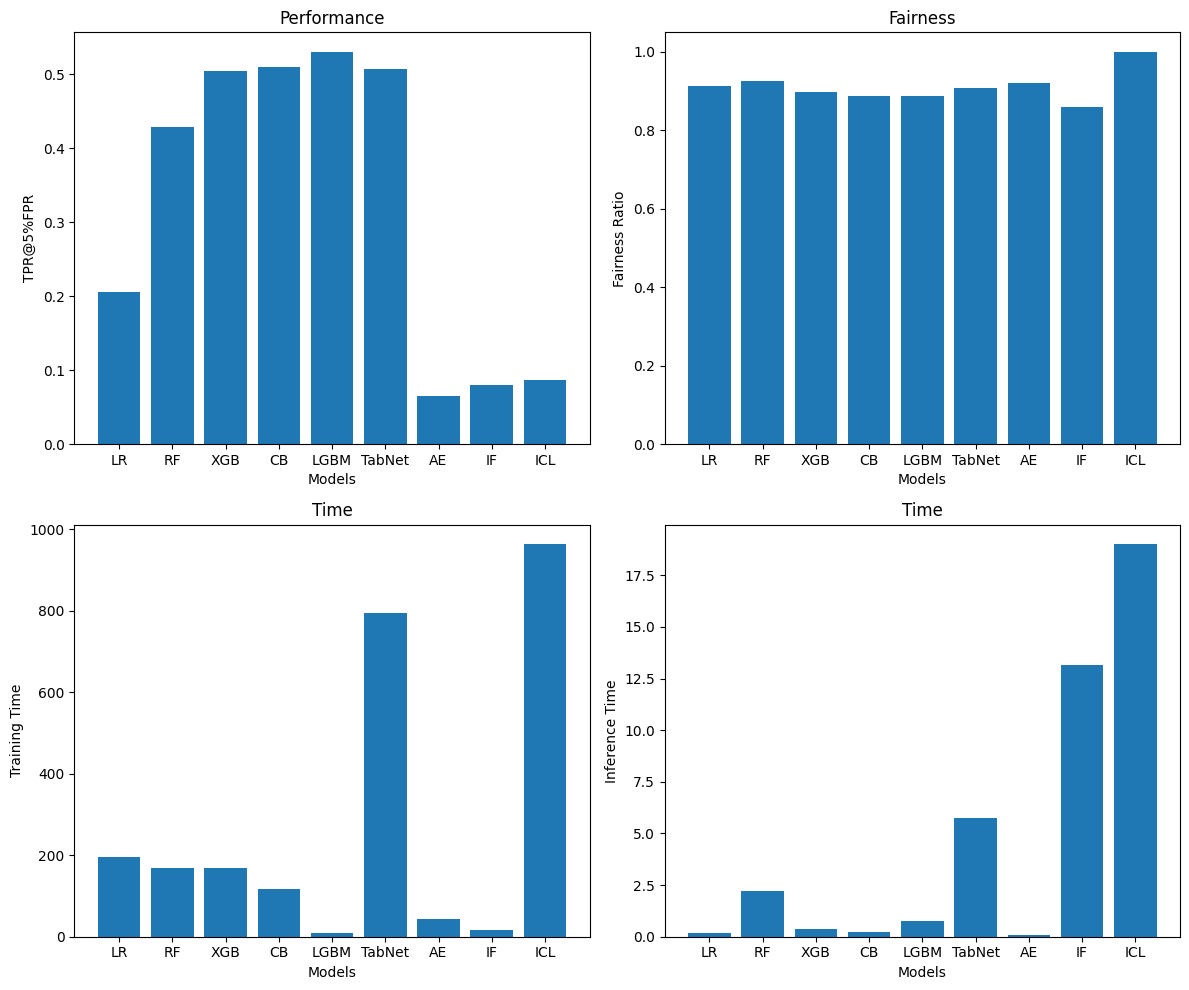

In [69]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

models = ['LR', 'RF', 'XGB', 'CB', 'LGBM', 'TabNet', 'AE', 'IF', 'ICL']

# Plot TPR values
axs[0, 0].bar(models, tpr_values)
axs[0, 0].set_xlabel('Models')
axs[0, 0].set_ylabel('TPR@5%FPR')
axs[0, 0].set_title('Performance')

# Plot Fairness Ratio values
axs[0, 1].bar(models, fn_values)
axs[0, 1].set_xlabel('Models')
axs[0, 1].set_ylabel('Fairness Ratio')
axs[0, 1].set_title('Fairness')

# Plot Training Time values
axs[1, 0].bar(models, tnt_values)
axs[1, 0].set_xlabel('Models')
axs[1, 0].set_ylabel('Training Time')
axs[1, 0].set_title('Time')

# Plot Inference Time values
axs[1, 1].bar(models, inf_values)
axs[1, 1].set_xlabel('Models')
axs[1, 1].set_ylabel('Inference Time')
axs[1, 1].set_title('Time')

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

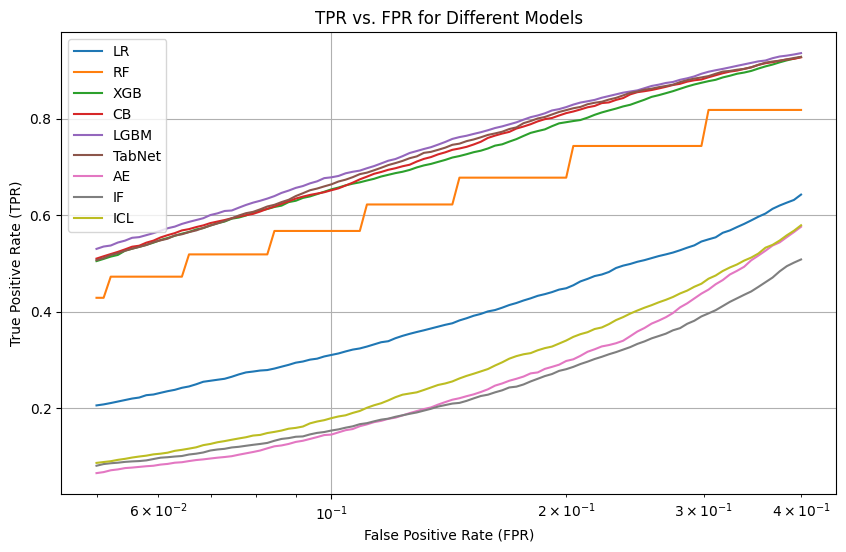

In [70]:
# Define the list of model names and their corresponding y_scores
model_names = ['LR', 'RF', 'XGB', 'CB', 'LGBM', 'TabNet', 'AE', 'IF', 'ICL']
y_scores_dict = {
    'LR': lr_scored_test,
    'RF': rf_scored_test,
    'XGB': xgb_scored_test,
    'CB': cb_scored_test,
    'LGBM': lgbm_scored_test,
    'TabNet': tabnet_scored_test,
    'AE': reconstruction_errors.numpy(),
    'IF': -isolation_scores,
    'ICL': icl_scored_test,
}

# Generate FPR values from 5% to 40%
fpr_values = np.logspace(np.log10(0.05), np.log10(0.4), num=100)

# Initialize a dictionary to store interpolated TPR values for each model
interpolated_tpr = {}

# Calculate TPR values for each model at the desired FPR points
for model_name in model_names:
    scored_test = y_scores_dict[model_name]
    tpr_list = [calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=i)['TPR'] for i in fpr_values]
    interpolated_tpr[model_name] = tpr_list

# Plotting
plt.figure(figsize=(10, 6))
for model_name, model_tpr_interp in interpolated_tpr.items():
    plt.plot(fpr_values, model_tpr_interp, label=model_name)

plt.xscale('log')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs. FPR for Different Models')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter Tuning

Hyperparameter tuning is the process of finding the best set of hyperparameters for a machine learning model to achieve optimal performance. Hyperparameters are configuration settings for a model that cannot be learned directly from the data and need to be set before training the model. They control various aspects of the learning process and can significantly impact the model's performance.

The provided code performs hyperparameter tuning for LightGBM on BAF dataset using the GridSearchCV method from scikit-learn. 

The code defines a custom metric function 'TPR_at_05FPR', which calculates the True Positive Rate (TPR) when the False Positive Rate (FPR) is at 5%. This custom metric will be used during the hyperparameter tuning process to optimize for TPR@5%FPR.

Hyperparameter grids for each model are defined in the 'param_grids' dictionary. Each model has different hyperparameters, and their possible values are specified in the dictionary. The hyperparameter tuning is performed within a loop that iterates over each model in the 'models' dictionary. For each model, GridSearchCV is used to find the best combination of hyperparameters from the corresponding 'param_grids' using the custom metric 'TPR_at_05FPR' as the scoring metric. The hyperparameter tuning is performed using 5-fold cross-validation.

After finding the best hyperparameters, the code trains the model on the training data using these optimized hyperparameters. Then, it predicts the target variable on the test data and evaluates the model's performance, which computes various metrics.

In [71]:
# Import the necessary packages and libraries
import pandas as pd
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from baf import BAFDataset
from metrics import calculate_tpr_at_fpr, calculate_fairness_metrics
import os
import joblib
import time
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define your custom metric function
def TPR_at_05FPR(y_test, scored_test):
    fpr, tpr, threshold = roc_curve(y_test, scored_test)
    tpr_at_05fpr = tpr[fpr < 0.05][-1]
    return tpr_at_05fpr

# Convert your custom metric function to a scorer object
custom_scorer = make_scorer(TPR_at_05FPR, greater_is_better=True)

# Hyperparameter grids for each model
# Here we only run the hyperparameter tuning for LightGBM
param_grids = {
    "LightGBM": {
        'num_leaves': [10, 25, 50],
        'min_data_in_leaf': [10, 25, 50],
        'max_depth': [1, 3, 5],
        'n_estimators': [50, 100, 200],
    }
}

# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# List of models to evaluate
models = {
    "LightGBM": lgbm.LGBMClassifier(),
}

# Instantiate the BAF class
ds = BAFDataset()

# set the path to the dataset and models
base_path = "/ssd003/projects/aieng/public/anomaly_detection_datasets/BAF"
variant = "Base.csv"

# Add file to path
file_path = os.path.join(base_path, variant)

# Load the dataset
df = ds.load_data(file_path)

# Split the dataset into train and test sets for the current variant
(X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

# One-hot encode the categorical features in the dataset
X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

# Loop over models
for model_name, model in models.items():
    print(f"Hyperparameter tuning for {model_name} on {variant.split('.')[0]}...")

    # Initialize dictionaries to store results
    performance_results[(variant.split('.')[0], model_name)] = {}
    fairness_results[(variant.split('.')[0], model_name)] = {}

    # Perform hyperparameter tuning using GridSearchCV
    param_grid = param_grids[model_name]
    # scoring should be 'roc_auc' if you want to optimize for AUROC
    # Here we want to maximize TPR@5%FPR
    search = GridSearchCV(model, param_grid, scoring=custom_scorer, cv=5, verbose=0)
    search.fit(X_train, y_train)

    # Get the best model with tuned hyperparameters
    best_model = search.best_estimator_

    # Train the best model
    best_model.fit(X_train, y_train)

    # Predict on the test set using the best model
    scored_test = best_model.predict_proba(X_test)[:, 1]

    # Calculate the TPR@5%FPR on the test set
    metrics_dict = calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05)
    performance_results[(variant.split('.')[0], model_name)] = metrics_dict
    print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")

    # Calculate the fairness metrics on the test set
    fairness_ratio = calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05)
    fairness_results[(variant.split('.')[0], model_name)]["Fairness Ratio"] = fairness_ratio
    print(f"Fairness Ratio: {fairness_ratio}", "\n")

Hyperparameter tuning for LightGBM on Base...
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min

Fairness Ratio: 0.8865 



In [72]:
# Access the best hyperparameters
best_hyperparameters = search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

Best Hyperparameters: {'max_depth': 5, 'min_data_in_leaf': 50, 'n_estimators': 200, 'num_leaves': 10}


In [73]:
df_performance_results = pd.DataFrame(performance_results).transpose()
df_performance_results

,,AUROC,FPR,TPR,Threshold
Base,LightGBM,0.8942,0.0499,0.5486,0.0414


In [74]:
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_fairness_results

,,Fairness Ratio
Base,LightGBM,0.8865


If you want to try more advanced hyperparameter tuning, you can try [Optuna](https://github.com/optuna/optuna).

<ul>
    <li>Optuna is an open-source hyperparameter optimization framework.</li><br>
    <li>It automates hyperparameter search for machine learning models.</li><br>
    <li>Optuna effectively explores the hyperparameter space to find the best configuration for model performance.</li><br>
    <li>It integrates seamlessly with popular machine learning libraries, including TensorFlow, Keras, PyTorch, Scikit-learn, etc</li><br>
</ul>

# Fraud Detection on Other Variants of BAF Dataset

This code applies LightGBM to other variants (Variant I, Variant II, Variant III, Variant IV, Variant V) of the BAF dataset for anomaly detection.

The code performs the following steps for each dataset variant:

1. Loads the BAF dataset variant.
2. Splits the dataset into training and test sets.
3. Performs one-hot encoding of categorical features.
4. Trains and evaluates the the model.
5. Store the training and inference time in dictionary
6. Calculates the TPR@5%FPR (True Positive Rate at 5% False Positive Rate) on the test set.
7. Computes fairness metrics based on the test set predictions.
8. Stores the results in a dictionary.

In [75]:
# Import the necessary packages and libraries
import pandas as pd
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
from baf import BAFDataset
from metrics import calculate_tpr_at_fpr, calculate_fairness_metrics
import os
import joblib
import time

In [76]:
# Instantiate the BAF class
ds = BAFDataset()

# set the path to the dataset and models
base_path = "/ssd003/projects/aieng/public/anomaly_detection_datasets/BAF"
model_path = "/ssd003/projects/aieng/public/anomaly_detection_models/BAF"

# define these dictionaries for storing the results
performance_results = {}
fairness_results = {}

# Dictionaries to store training and inference times
training_times_dict = {}
inference_times_dict = {}

# List of variants and their corresponding file names
variants = {
    'Variant I': 'Variant I.csv',
    'Variant II': 'Variant II.csv',
    'Variant III': 'Variant III.csv',
    'Variant IV': 'Variant IV.csv',
    'Variant V': 'Variant V.csv',
}

# List of models to evaluate
models = {
    "LightGBM": lgbm.LGBMClassifier(),
}

# Loop over variants and models
for variant, file_name in variants.items():
    print(f"Loading data for {variant}...")
    
    # Load data from CSV file
    df = pd.read_csv(os.path.join(base_path, file_name))

    # Split the dataset into train and test sets for the current variant
    (X_train, y_train), (X_test, y_test) = ds.train_test_split(df, month=6)

    # One-hot encode the categorical features in the dataset
    X_train, X_test = ds.one_hot_encode_categorical(X_train, X_test)

    # Loop over models
    for model_name, model in models.items():
        print(f"Training and evaluating {model_name} on {variant}...")
        
        # Initialize dictionaries to store results
        training_times_dict[(variant, model_name)] = {}
        inference_times_dict[(variant, model_name)] = {}
        performance_results[(variant, model_name)] = {}
        fairness_results[(variant, model_name)] = {}

        # Start measuring training time
        start_time = time.time()

        # Train the model
        model.fit(X_train, y_train)

        # End measuring training time
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training Time: {training_time} seconds")
        training_times_dict[(variant, model_name)]["Training Time"] = training_time

        # Save the model
        path_to_model = os.path.join(model_path, f"{variant}_{model_name.replace(' ', '_').lower()}_model.joblib")
        joblib.dump(model, path_to_model)

        # Start measuring inference time
        start_time = time.time()

        # Predict on the test set
        scored_test = model.predict_proba(X_test)[:, 1]

        # End measuring inference time
        end_time = time.time()
        inference_time = end_time - start_time
        print(f"Inference Time: {inference_time} seconds")
        inference_times_dict[(variant, model_name)]["Inference Time"] = inference_time

        # Calculate the TPR@5%FPR on the test set
        metrics_dict = calculate_tpr_at_fpr(y_test, scored_test, fpr_lim=0.05)
        print(f"Model TPR: {metrics_dict['TPR']}, Model FPR: {metrics_dict['FPR']}, Model Threshold: {metrics_dict['Threshold']}, Model AUROC: {metrics_dict['AUROC']}")
        performance_results[(variant, model_name)] = metrics_dict

        # Calculate the fairness metrics on the test set
        fairness_ratio = calculate_fairness_metrics(y_test, scored_test, X_test, fpr_lim=0.05)
        fairness_results[(variant, model_name)]["Fairness Ratio"] = fairness_ratio
        print(f"Fairness Ratio: {fairness_ratio}", "\n")
    print('\n\n')

Loading data for Variant I...
Training and evaluating LightGBM on Variant I...
Training Time: 9.445932626724243 seconds
Inference Time: 0.6934473514556885 seconds
Model TPR: 0.5038, Model FPR: 0.0499, Model Threshold: 0.0425, Model AUROC: 0.8842
Fairness Ratio: 0.9828 




Loading data for Variant II...
Training and evaluating LightGBM on Variant II...
Training Time: 8.872501373291016 seconds
Inference Time: 0.7572717666625977 seconds
Model TPR: 0.5323, Model FPR: 0.0499, Model Threshold: 0.0408, Model AUROC: 0.8927
Fairness Ratio: 0.9108 




Loading data for Variant III...
Training and evaluating LightGBM on Variant III...
Training Time: 8.921825885772705 seconds
Inference Time: 0.7963011264801025 seconds
Model TPR: 0.7413, Model FPR: 0.0498, Model Threshold: 0.0254, Model AUROC: 0.9513
Fairness Ratio: 0.9204 




Loading data for Variant IV...
Training and evaluating LightGBM on Variant IV...
Training Time: 8.512253999710083 seconds
Inference Time: 0.8486287593841553 seconds
Model T

## Result

The table below shows all results for LightGBM on other variants of BAF dataset:

In [77]:
# Create a DataFrame from all results
df_performance_results = pd.DataFrame(performance_results).transpose()
df_fairness_results = pd.DataFrame(fairness_results).transpose()
df_training_times_dict = pd.DataFrame(training_times_dict).transpose()
df_inference_times_dict = pd.DataFrame(inference_times_dict).transpose()

In [78]:
# concatenate all results together
all_results = pd.concat([df_performance_results, df_fairness_results, df_training_times_dict, df_inference_times_dict], axis=1)

In [79]:
all_results

,,TPR,FPR,Threshold,AUROC,Fairness Ratio,Training Time,Inference Time
Variant I,LightGBM,0.5038,0.0499,0.0425,0.8842,0.9828,9.445933,0.693447
Variant II,LightGBM,0.5323,0.0499,0.0408,0.8927,0.9108,8.872501,0.757272
Variant III,LightGBM,0.7413,0.0498,0.0254,0.9513,0.9204,8.921826,0.796301
Variant IV,LightGBM,0.4023,0.0499,0.0431,0.8477,0.9136,8.512254,0.848629
Variant V,LightGBM,0.3375,0.0497,0.0251,0.7824,0.9288,8.906422,0.832853


# References:





<ul>
    <li>Jesus S, Pombal J, Alves D, Cruz A, Saleiro P, Ribeiro R, Gama J, Bizarro P. Turning the tables: Biased, imbalanced, dynamic tabular datasets for ml evaluation. Advances in Neural Information Processing Systems. 2022 Dec 6;35:33563-75.</li>

</ul>